## HD_sEMG Preprocessing and Plotting

This Python script processes HD-sEMG data from multiple participants to identify noisy channels, filter signals, compute bipolar signals, and extract EMG envelopes for further analysis. Key steps:

- **Global Setup**: Configures participants, data paths, electrode grid shapes, and auxiliary channel settings. Defines desired file order and sampling rate (2000 Hz).
- **Data Loading & Preprocessing**: Loads CSV files containing EMG data. Trims initial samples, selects valid channels, and identifies noisy channels based on RMS, activity percentage, power ratio, and amplitude.
- **Filtering**: Applies bandpass (10–500 Hz) and notch (50 Hz + harmonics) filters to clean the EMG data.
- **Bipolar Signal Computation**: Calculates bipolar signals between electrode pairs on two grids, excluding noisy channels.
- **Rectification & Envelope Extraction**: Rectifies the signals and extracts envelopes using low-pass filtering for further analysis.
- **Normalization**: Computes a global maximum across all envelopes within each matched group of trials, ensuring consistent scaling of signals across groups and trials.
- **Visualization**: 
  - Plots raw, filtered, and processed signals for all channels.
  - Visualizes monopolar and bipolar EMG grid signals, distinguishing good vs. noisy signals.
  - Provides step-by-step signal processing plots for single channels and stacked views.
- **Main Workflow**: Iterates over participants and file groups, processes data through the pipeline, and saves results (e.g., cleaned signals, bipolar signals, envelopes, bad channels) in structured directories.



Processing file C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(1)\otb+\emg_data_20241028_104216567.csv
Overall identified bad channels (across all grids): [2, 52, 53, 66, 72, 73, 74, 75, 82, 83, 84, 85, 86, 87, 88, 97, 98, 99, 100, 101, 111, 112, 113, 114, 124, 125, 126, 127]

[DEBUG] ----- Calculating Bipolar Signals -----
[DEBUG] Electrode Grid 1:
 [[-1  1  2  3  4  5  6  7  8  9 10 11 12]
 [13 14 15 16 17 18 19 20 21 22 23 24 25]
 [26 27 28 29 30 31 32 33 34 35 36 37 38]
 [39 40 41 42 43 44 45 46 47 48 49 50 51]
 [52 53 54 55 56 57 58 59 60 61 62 63 64]]
[DEBUG] Electrode Grid 2:
 [[12 25 38 51 64]
 [11 24 37 50 63]
 [10 23 36 49 62]
 [ 9 22 35 48 61]
 [ 8 21 34 47 60]
 [ 7 20 33 46 59]
 [ 6 19 32 45 58]
 [ 5 18 31 44 57]
 [ 4 17 30 43 56]
 [ 3 16 29 42 55]
 [ 2 15 28 41 54]
 [ 1 14 27 40 53]
 [-1 13 26 39 52]]
[DEBUG] EMG Signal Shape: (128, 83600)
[DEBUG] Bad Channels: [  2  52  53  66  72  73  74  75  82  83  84  85  86  87  88  97  98  99
 100 

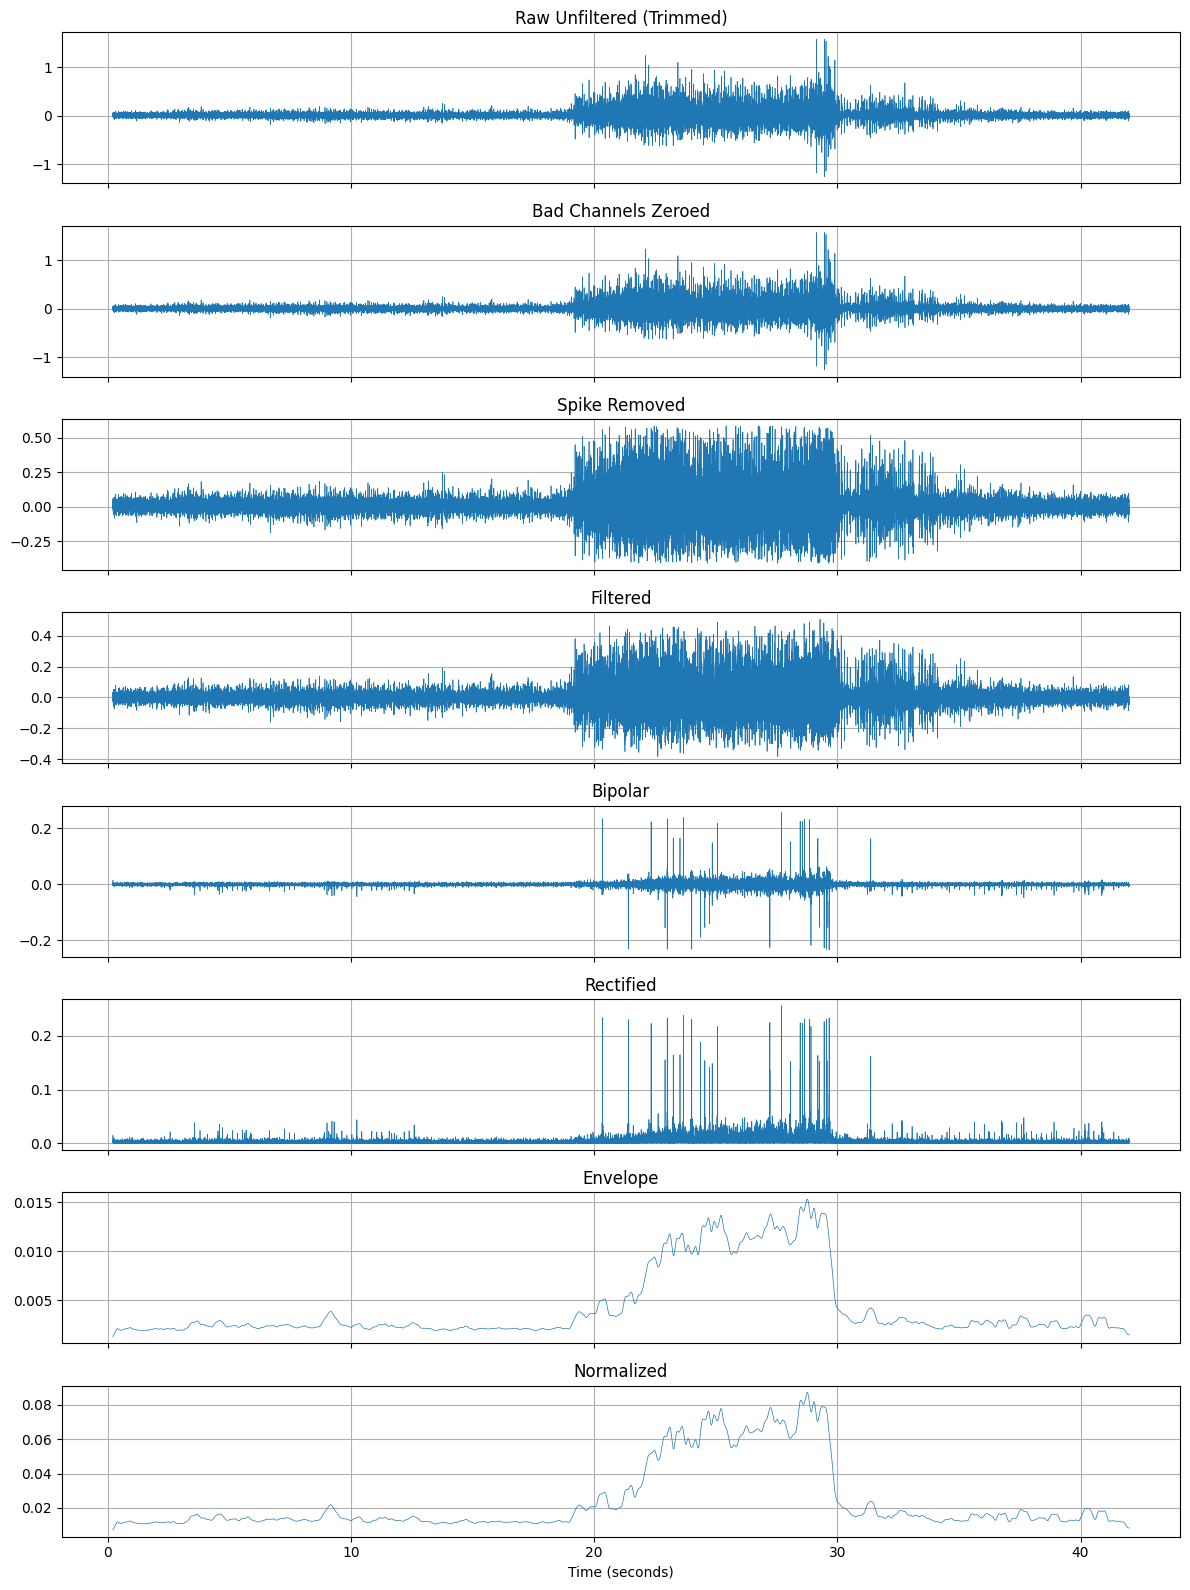

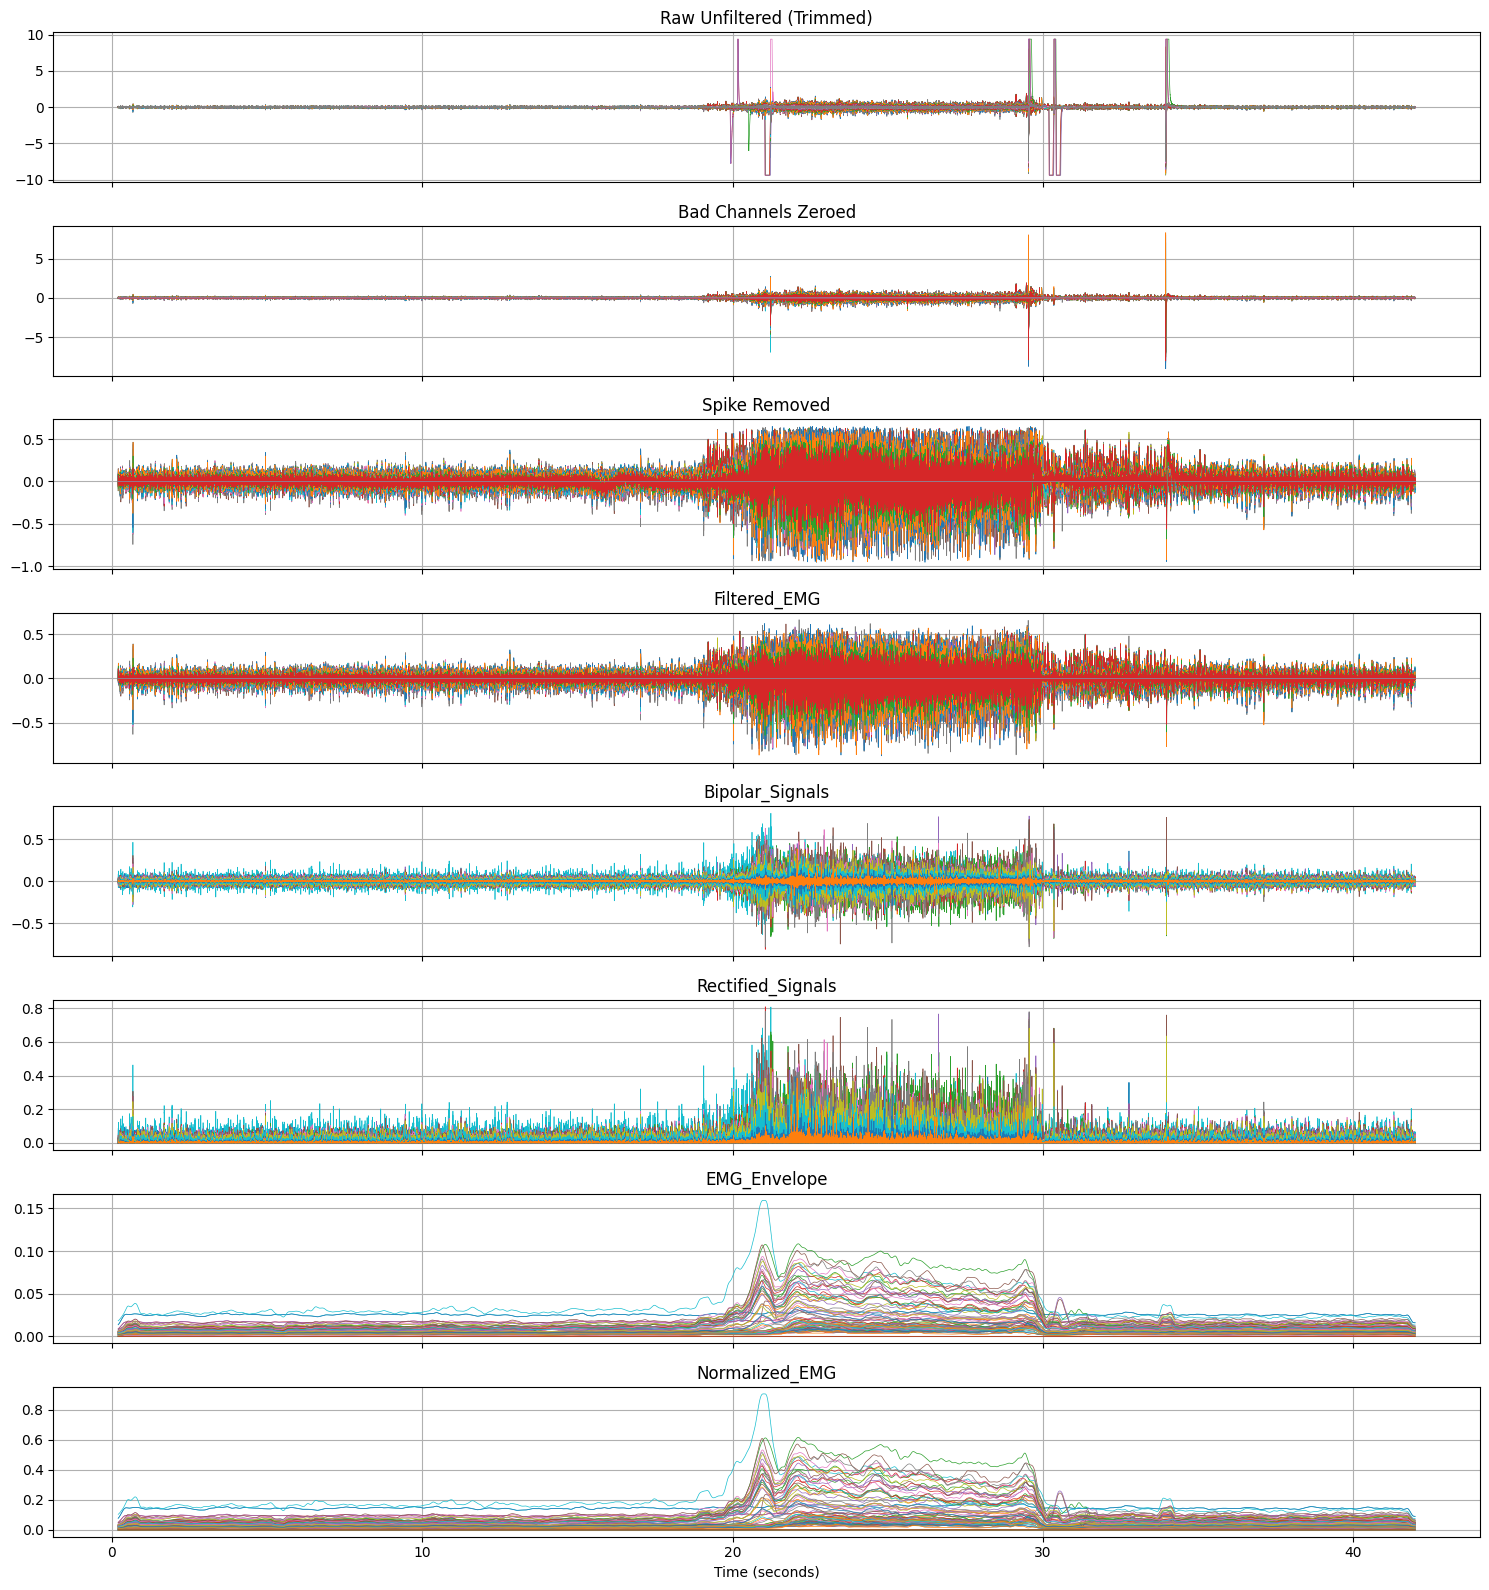

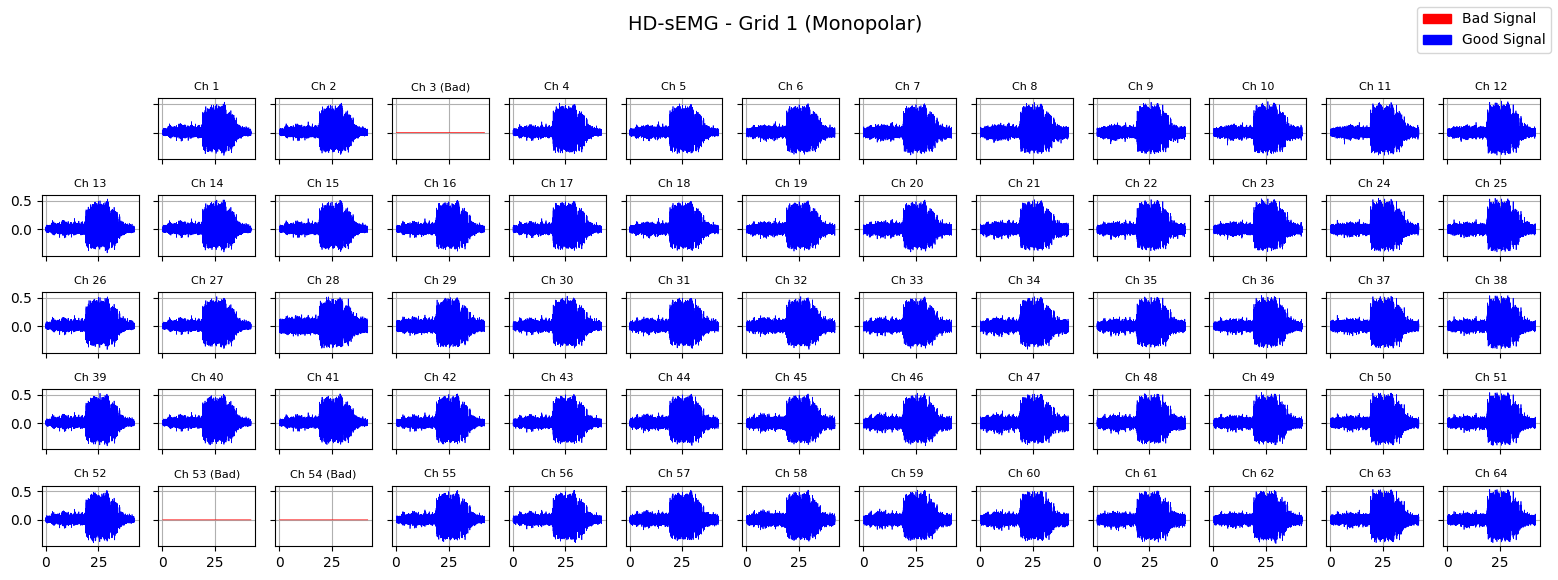

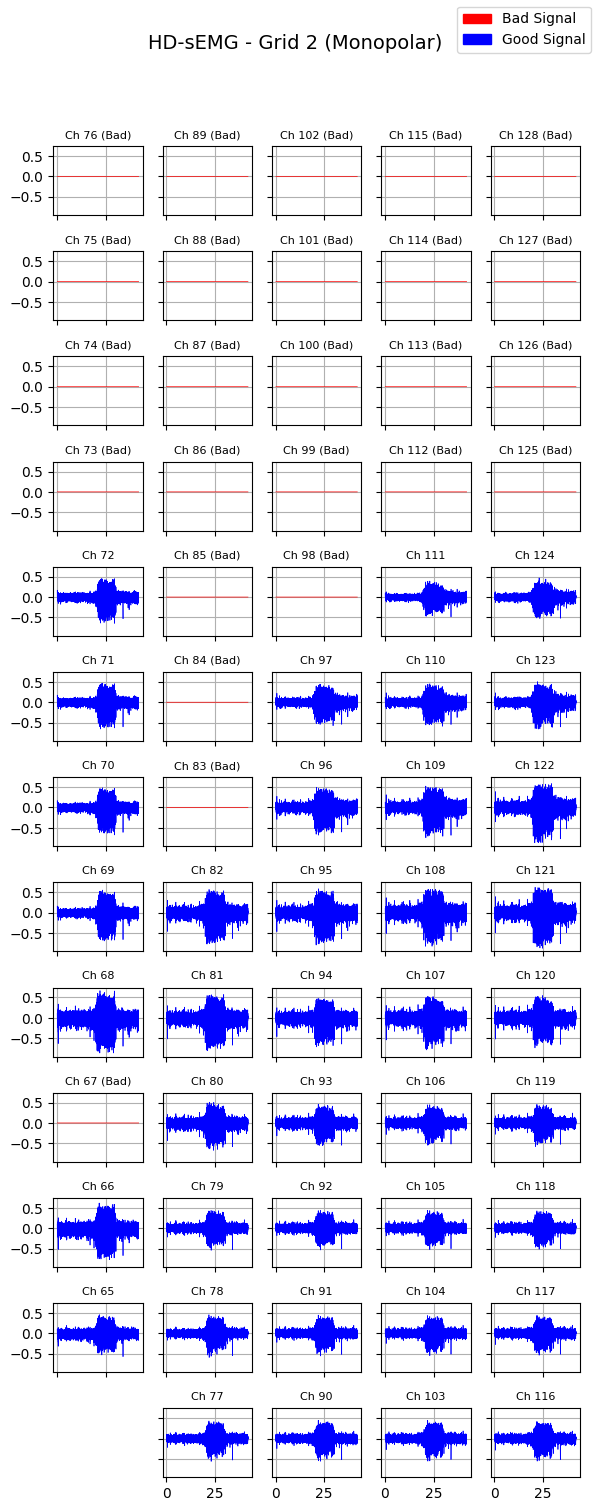

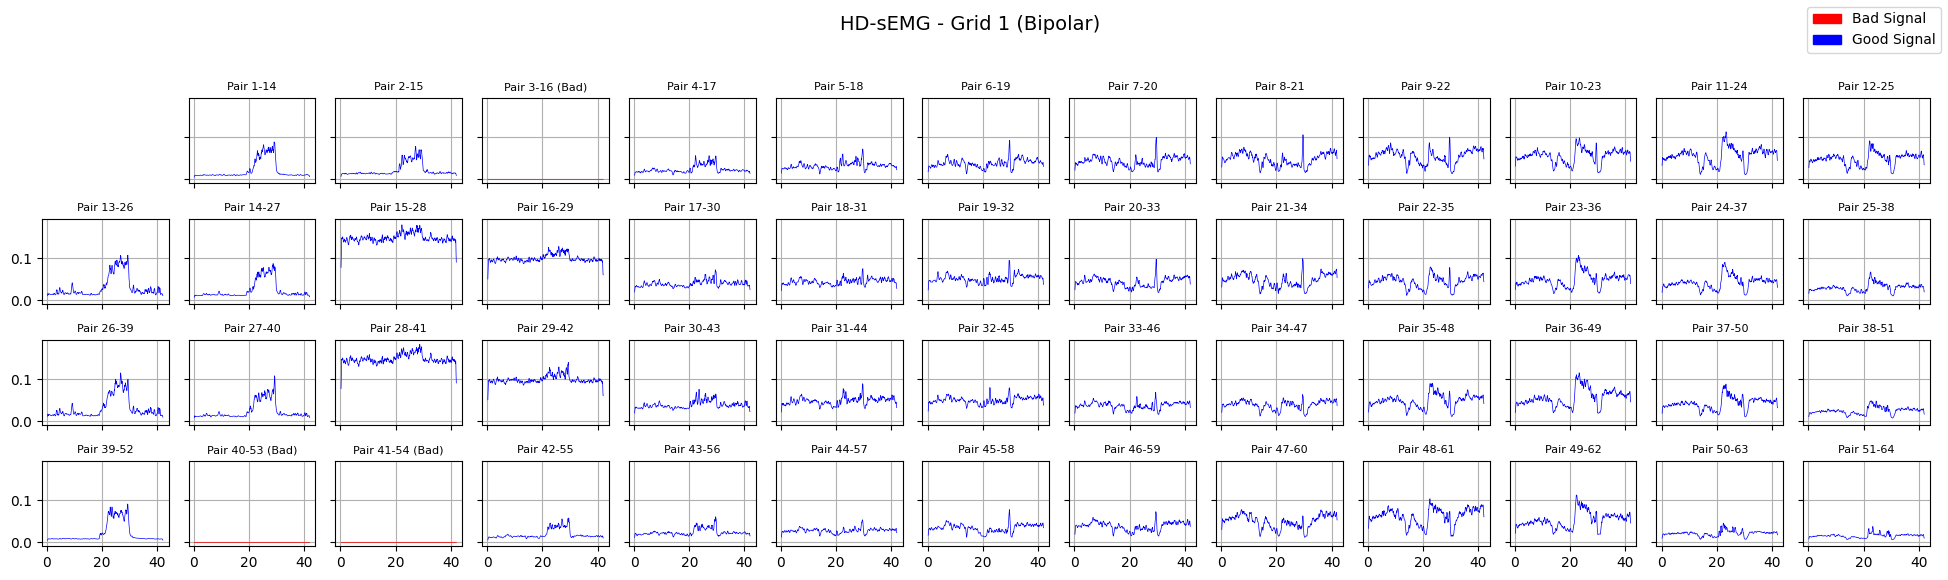

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  
from scipy.signal import butter, filtfilt, welch, iirnotch
from datetime import datetime

# ------------------------------------------------------
# Helper Data Loading Functions
# ------------------------------------------------------

def generate_electrode_grid_mapping(n_rows=5, n_cols=13):
    """
    Generate a 5x13 electrode grid mapping with the top-left cell missing (-1).
    The numbering runs row-wise from left to right, skipping the first cell (0,0).

    For example:
    Row 0: -1, 1, 2, 3, ... 12
    Row 1: 13, 14, 15, ... 25
    ...
    Row 4: 52, 53, ... 64
    """
    electrode_grid = np.full((n_rows, n_cols), -1, dtype=int)
    
    idx = 1
    for row in range(n_rows):
        for col in range(n_cols):
            if row == 0 and col == 0:
                # Missing electrode at top-left
                continue
            electrode_grid[row, col] = idx
            idx += 1

    return electrode_grid

def get_valid_electrode_indices(n_rows=5, n_cols=13):
    """
    Get a list of valid electrode indices, excluding the missing first electrode.

    Parameters:
    - n_rows: Number of rows in the grid.
    - n_cols: Number of columns in the grid.

    Returns:
    - valid_indices: List of valid electrode indices.
    """
    valid_indices = []
    idx = 0
    for row in range(n_rows):
        for col in range(n_cols):
            if row == 0 and col == 0:
                continue  # Skip the missing electrode
            valid_indices.append(idx)
            idx += 1
    return valid_indices

def parse_filename_timestamp(filename):
    base_name = os.path.splitext(filename)[0]
    prefix = "emg_data_"
    time_str = base_name[len(prefix):]
    dt = datetime.strptime(time_str, "%Y%m%d_%H%M%S%f")
    return dt

# ------------------------------------------------------
# Filter Functions
# ------------------------------------------------------

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, fs, lowcut=10, highcut=500, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data, axis=1)

def iir_notch_filter(data, fs, freq=50, Q=30):
    """
    Infinite Impulse Response Notch Filter for Powerline frequency (50Hz and Harmonics)
    """
    w0 = freq / (fs / 2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, data, axis=1)

def apply_notch_filter(data, fs, freq=50, Q=30, harmonics=8):
    filtered_data = data.copy()
    for h in range(1, harmonics+1):
        notch_freq = freq * h
        filtered_data = iir_notch_filter(filtered_data, fs, freq=notch_freq, Q=Q)
    return filtered_data

def identify_noisy_channels(emg_signal, fs, electrode_shape, n_grids=2,
                            rms_lower_scale=0.7, rms_upper_scale=1.3,
                            pl_upper_scale=1.4, active_threshold=0.75,
                            amp_threshold=0.75, top_percent=20):
    """
    Identify and return bad/noisy channels across all grids.
    
    Arguments:
    ----------
    emg_signal : np.ndarray
        2D array of shape (n_channels, n_samples).
    fs : float
        Sampling frequency in Hz.
    electrode_shape : tuple
        (rows, cols) shape of one grid of electrodes (not explicitly used here, 
        but often helpful for indexing).
    n_grids : int
        Number of HD-EMG grids.
    rms_lower_scale, rms_upper_scale : float
        Scales for the IQR-based RMS thresholds (lower and upper).
    pl_upper_scale : float
        Scale for the IQR-based low-frequency drift threshold.
    active_threshold : float
        Fraction of time the channel must be non-zero to be considered active.
    amp_threshold : float
        Percentage (0–1) of the average peak metric below which a channel is flagged low.
    top_percent : float
        Percentage of top values (by amplitude) used to define the "peak metric."
    """

    bad_channels_all = np.array([])

    n_electrodes = emg_signal.shape[0] // n_grids
    n_samples = emg_signal.shape[1]

    for grid in range(n_grids):
        start_idx = grid * n_electrodes
        end_idx = start_idx + n_electrodes
        emg_grid = emg_signal[start_idx:end_idx]

        rms_values = []
        pl_values = []
        active_percentage = []

        # ------------------------------------------------------
        # 1. RMS Calculation
        # ------------------------------------------------------
        for channel in range(emg_grid.shape[0]):
            rms = np.sqrt(np.mean(np.square(emg_grid[channel, :])))
            rms_values.append(rms)
        rms_values = np.array(rms_values)

        Q1_rms, Q3_rms = np.percentile(rms_values, [25, 75])
        IQR_rms = Q3_rms - Q1_rms
        lower_bound_rms = Q1_rms - 1.5 * IQR_rms
        upper_bound_rms = Q3_rms + 1.5 * IQR_rms

        scaled_lower_bound_rms = rms_lower_scale * lower_bound_rms
        scaled_upper_bound_rms = rms_upper_scale * upper_bound_rms

        bad_rms_channels = np.where((rms_values < scaled_lower_bound_rms) |
                                    (rms_values > scaled_upper_bound_rms))[0]

        # ------------------------------------------------------
        # 2. Low-Frequency Drift Calculation (Power-Low Ratio)
        # ------------------------------------------------------
        epoch_duration = 2  # seconds
        n_epochs = n_samples // int(epoch_duration * fs)
        n_samples_epoch = int(epoch_duration * fs)

        for channel in range(emg_grid.shape[0]):
            channel_signal = emg_grid[channel, :]
            pl_epoch_values = []
            for epoch_idx in range(n_epochs):
                start = epoch_idx * n_samples_epoch
                end = start + n_samples_epoch
                epoch_signal = channel_signal[start:end]
                if len(epoch_signal) == 0:
                    continue
                freqs, psd = welch(epoch_signal, fs, nperseg=len(epoch_signal))
                total_power = np.sum(psd) + 1e-10
                low_freq_power = np.sum(psd[(freqs >= 0) & (freqs <= 12)])
                pl_epoch_values.append(low_freq_power / total_power)
            if pl_epoch_values:
                pl_values.append(np.nanmean(pl_epoch_values))
            else:
                pl_values.append(np.nan)

        pl_values = np.array(pl_values)
        pl_values_clean = pl_values[~np.isnan(pl_values)]
        if len(pl_values_clean) > 0:
            Q1_pl, Q3_pl = np.percentile(pl_values_clean, [25, 75])
            IQR_pl = Q3_pl - Q1_pl
            upper_bound_pl = Q3_pl + 1.5 * IQR_pl
            scaled_upper_bound_pl = pl_upper_scale * upper_bound_pl
            bad_pl_channels = np.where(pl_values > scaled_upper_bound_pl)[0]
        else:
            bad_pl_channels = np.array([])

        # ------------------------------------------------------
        # 3. Activity Percentage
        # ------------------------------------------------------
        for channel in range(emg_grid.shape[0]):
            active_pct = np.count_nonzero(emg_grid[channel, :]) / n_samples
            active_percentage.append(active_pct)
        active_percentage = np.array(active_percentage)

        bad_activity_channels = np.where(active_percentage < active_threshold)[0]

        # ------------------------------------------------------
        # 4. Low-Amplitude Detection (new step)
        # ------------------------------------------------------
        peak_values = []
        for channel in range(emg_grid.shape[0]):
            # Sort absolute values to find top portion
            channel_data_abs = np.abs(emg_grid[channel, :])
            sorted_data = np.sort(channel_data_abs)
            top_n = max(1, int(np.ceil(len(sorted_data) * (top_percent / 100.0))))
            top_values = sorted_data[-top_n:]  # last "top_n" entries are the largest
            peak_values.append(np.mean(top_values))

        peak_values = np.array(peak_values)
        global_peak_mean = np.mean(peak_values)
        # Flag channels whose mean-of-top-values is < 70% of global mean
        bad_amplitude_channels = np.where(peak_values < amp_threshold * global_peak_mean)[0]

        # ------------------------------------------------------
        # Consolidate bad channels for this grid
        # ------------------------------------------------------
        bad_channels = np.unique(
            np.concatenate(
                (
                    bad_rms_channels,
                    bad_pl_channels,
                    bad_activity_channels,
                    bad_amplitude_channels
                )
            )
        ).astype(int)

        # Map to overall channel indices
        bad_channels_all = np.concatenate((bad_channels_all, bad_channels + grid * n_electrodes))

    total_bad_channels = np.unique(bad_channels_all).astype(int)
    print(f"Overall identified bad channels (across all grids): {total_bad_channels.tolist()}")
    return total_bad_channels

def remove_spikes_percentile(data, upper_percentile=99.8, lower_percentile=0.2, window_size=100, replacement_method='median'):
    """
    Spike removal function that replaces samples beyond certain percentile thresholds.
    """
    data = np.asarray(data)

    if data.ndim == 1:
        return remove_spikes_1d(data, upper_percentile, lower_percentile, window_size, replacement_method)
    elif data.ndim == 2:
        clean_data = np.zeros_like(data)
        for i in range(data.shape[0]):
            clean_data[i, :] = remove_spikes_1d(data[i, :], upper_percentile, lower_percentile, window_size, replacement_method)
        return clean_data
    else:
        raise ValueError("Input data must be a 1D or 2D array.")

def remove_spikes_1d(data, upper_percentile, lower_percentile, window_size, replacement_method='median'):
    upper_thresh = np.percentile(data, upper_percentile)
    lower_thresh = np.percentile(data, lower_percentile)

    spike_indices = np.where((data > upper_thresh) | (data < lower_thresh))[0]

    clean_data = data.copy()

    for idx in spike_indices:
        start_idx = max(0, idx - window_size)
        end_idx = min(len(data), idx + window_size + 1)

        neighbors = np.concatenate((clean_data[start_idx:idx], clean_data[idx + 1:end_idx]))
        if len(neighbors) == 0:
            replacement_value = 0
        else:
            if replacement_method == 'median':
                replacement_value = np.median(neighbors)
            elif replacement_method == 'mean':
                replacement_value = np.mean(neighbors)
            else:
                raise ValueError("replacement_method must be 'mean' or 'median'")

        clean_data[idx] = replacement_value

    return clean_data

def calculate_bipolar_signals(emg_signal, electrode_shape, bad_channels, n_grids=2):
    if n_grids != 2:
        raise ValueError("Currently, only 2 grids are supported.")

    n_rows, n_cols = electrode_shape
    n_electrodes_per_grid = emg_signal.shape[0] // n_grids

    # Generate the original electrode grid
    electrode_grid1 = generate_electrode_grid_mapping(n_rows, n_cols)
    # Rotate for second grid
    electrode_grid2 = np.rot90(electrode_grid1, k=1)  # 90° CCW rotation

    print("\n[DEBUG] ----- Calculating Bipolar Signals -----")
    print("[DEBUG] Electrode Grid 1:\n", electrode_grid1)
    print("[DEBUG] Electrode Grid 2:\n", electrode_grid2)
    print("[DEBUG] EMG Signal Shape:", emg_signal.shape)
    print("[DEBUG] Bad Channels:", bad_channels)
    print("[DEBUG] Number of Electrodes per Grid:", n_electrodes_per_grid)

    # Extract signals for each grid
    grid_signal_1 = emg_signal[0:n_electrodes_per_grid, :]
    grid_signal_2 = emg_signal[n_electrodes_per_grid:n_electrodes_per_grid*2, :]

    rows_g2, cols_g2 = electrode_grid2.shape

    pair_grid_1 = [[None for _ in range(n_cols)] for _ in range(n_rows - 1)]
    pair_grid_2 = [[None for _ in range(cols_g2)] for _ in range(rows_g2 - 1)]

    bipolar_signals_list = []

    print("[DEBUG] Processing Grid 1 Pairs:")
    start_idx_1 = 0
    g1_pair_count = 0
    for col_idx in range(n_cols):
        for row_idx in range(n_rows - 1):
            ch1_id = electrode_grid1[row_idx, col_idx]
            ch2_id = electrode_grid1[row_idx + 1, col_idx]

            if ch1_id == -1 or ch2_id == -1:
                bipolar_signal = np.zeros_like(grid_signal_1[0, :])
                print(f"[DEBUG] Grid1 Pair (row={row_idx}, col={col_idx}): Invalid electrode -1 found. ch1_id={ch1_id}, ch2_id={ch2_id}, skipping bipolar signal")
            else:
                ch1 = ch1_id - 1
                ch2 = ch2_id - 1
                global_ch1 = ch1 + start_idx_1
                global_ch2 = ch2 + start_idx_1

                print(f"[DEBUG] Grid1 Pair (row={row_idx}, col={col_idx}): ch1_id={ch1_id}, ch2_id={ch2_id}, global_ch1={global_ch1}, global_ch2={global_ch2}")

                if (global_ch1 in bad_channels) or (global_ch2 in bad_channels):
                    bipolar_signal = np.zeros_like(grid_signal_1[0, :])
                    print(f"[DEBUG] -> One or both channels are bad (ch1={global_ch1} or ch2={global_ch2}). Zeroing signal.")
                else:
                    bipolar_signal = grid_signal_1[ch1, :] - grid_signal_1[ch2, :]
                    print(f"[DEBUG] -> Subtracting: Channel {global_ch1} - Channel {global_ch2}")

            pair_grid_1[row_idx][col_idx] = (ch1_id, ch2_id, bipolar_signal)
            bipolar_signals_list.append(bipolar_signal)
            g1_pair_count += 1

    print(f"[DEBUG] Total pairs (Grid 1): {g1_pair_count}")

    print("[DEBUG] Processing Grid 2 Pairs:")
    start_idx_2 = n_electrodes_per_grid
    g2_pair_count = 0
    for col_idx in range(cols_g2):
        for row_idx in range(rows_g2 - 1):
            ch1_id = electrode_grid2[row_idx, col_idx]
            ch2_id = electrode_grid2[row_idx + 1, col_idx]

            if ch1_id == -1 or ch2_id == -1:
                bipolar_signal = np.zeros_like(grid_signal_2[0, :])
                print(f"[DEBUG] Grid2 Pair (row={row_idx}, col={col_idx}): Invalid electrode -1 found. ch1_id={ch1_id}, ch2_id={ch2_id}, Zeroing signal.")
            else:
                ch1 = ch1_id - 1
                ch2 = ch2_id - 1
                global_ch1 = ch1 + start_idx_2
                global_ch2 = ch2 + start_idx_2

                print(f"[DEBUG] Grid2 Pair (row={row_idx}, col={col_idx}): ch1_id={ch1_id}, ch2_id={ch2_id}, global_ch1={global_ch1}, global_ch2={global_ch2}")

                if (global_ch1 in bad_channels) or (global_ch2 in bad_channels):
                    bipolar_signal = np.zeros_like(grid_signal_2[0, :])
                    print(f"[DEBUG] -> One or both channels are bad (ch1={global_ch1} or ch2={global_ch2}). Zeroing signal.")
                else:
                    bipolar_signal = grid_signal_2[ch1, :] - grid_signal_2[ch2, :]
                    print(f"[DEBUG] -> Subtracting: Channel {global_ch1} - Channel {global_ch2}")

            pair_grid_2[row_idx][col_idx] = (ch1_id, ch2_id, bipolar_signal)
            bipolar_signals_list.append(bipolar_signal)
            g2_pair_count += 1

    print(f"[DEBUG] Total pairs (Grid 2): {g2_pair_count}")
    print(f"[DEBUG] Total Bipolar Signals Computed: {len(bipolar_signals_list)}")

    bipolar_signals = np.array(bipolar_signals_list)
    print("\n[DEBUG] Returning from calculate_bipolar_signals:")
    print("[DEBUG] bipolar_signals.shape:", bipolar_signals.shape)
    print("[DEBUG] pair_grid_1 dimensions: {} rows, {} cols".format(len(pair_grid_1), len(pair_grid_1[0])))
    print("[DEBUG] pair_grid_2 dimensions: {} rows, {} cols".format(len(pair_grid_2), len(pair_grid_2[0])))

    valid_pairs_1 = sum(1 for row in pair_grid_1 for cell in row if cell[0] != -1 and cell[1] != -1)
    valid_pairs_2 = sum(1 for row in pair_grid_2 for cell in row if cell[0] != -1 and cell[1] != -1)
    print("[DEBUG] Number of valid pairs in pair_grid_1:", valid_pairs_1)
    print("[DEBUG] Number of valid pairs in pair_grid_2:", valid_pairs_2)
    print("[DEBUG] Total number of valid bipolar pairs:", valid_pairs_1 + valid_pairs_2)
    print("[DEBUG] Length of bipolar_signals_list:", len(bipolar_signals_list))

    return bipolar_signals, pair_grid_1, pair_grid_2

def rectify_signal(emg_signal):
    return np.abs(emg_signal)

def extract_envelope(emg_signal, fs, cutoff_freq=5, window_size=800):
    nyq = 0.5 * fs
    low = cutoff_freq / nyq
    b, a = butter(4, low, btype='low')

    if window_size > 0:
        ma_filter = np.ones(window_size) / window_size
        emg_signal = np.apply_along_axis(lambda x: np.convolve(x, ma_filter, mode='same'), axis=1, arr=emg_signal)

    envelope = filtfilt(b, a, emg_signal, axis=1)
    return envelope

def normalize_emg(emg_signal, global_max):
    if global_max == 0:
        global_max = 1e-10
    normalized_signal = emg_signal / global_max
    return normalized_signal

# ------------------------------------------------------
# Plotting functions
# ----------------------------------------------------

def plot_all_channels(emg_file_path, fs):
    # Load the data
    emg_data = pd.read_csv(emg_file_path, delimiter=',', header=None).to_numpy()

    # Define time vector
    n_samples = emg_data.shape[0]
    time = np.arange(n_samples) / fs

    # Set up the figure for 147 subplots
    n_channels = emg_data.shape[1]
    fig, axes = plt.subplots(n_channels, 1, figsize=(15, 2 * n_channels), sharex=True)
    fig.suptitle("Raw Signals: HD-sEMG Grids, IMU, and Auxiliary Channels", fontsize=16)

    # Plot each channel
    for i in range(n_channels):
        axes[i].plot(time, emg_data[:, i], lw=0.5)
        if i < 64:
            axes[i].set_ylabel(f"Grid 1\nCh {i}", fontsize=8)
        elif i < 128:
            axes[i].set_ylabel(f"Grid 2\nCh {i - 64}", fontsize=8)
        else:
            axes[i].set_ylabel(f"Aux\nCh {i - 128}", fontsize=8)
        axes[i].tick_params(axis='y', which='major', labelsize=6)
        axes[i].grid(True, which='both', lw=0.25, linestyle='--')

    # Set x-axis label on the last subplot
    axes[-1].set_xlabel("Time (s)", fontsize=10)

    # Adjust layout to avoid overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_signals_stacked(time, step_signals, processed_folder, processed_filename, plot_flag):
    n_steps = len(step_signals)
    fig, axes = plt.subplots(n_steps, 1, figsize=(15, n_steps * 2), sharex=True)
    if n_steps == 1:
        axes = [axes]

    for idx, (step_name, signals) in enumerate(step_signals.items()):
        axes[idx].plot(time, signals.T, linewidth=0.5)
        axes[idx].set_title(step_name)
        axes[idx].grid(True)

    # Add xlabel with unit "seconds" to the last subplot
    axes[-1].set_xlabel("Time (seconds)")

    plt.tight_layout()
    if plot_flag:
        plt.show()
    else:
        plot_path = os.path.join(processed_folder, f"{processed_filename}_all_channels_stacked.png")
        plt.savefig(plot_path)
        plt.close(fig)
        print(f"All-channels stacked plot saved to {plot_path}")

def plot_processing_steps(time, steps_dict, processed_folder, processed_filename, plot_flag, single_channel_idx=0):
    step_names = list(steps_dict.keys())
    n_steps = len(step_names)
    fig, axes = plt.subplots(n_steps, 1, figsize=(12, n_steps * 2), sharex=True)

    if n_steps == 1:
        axes = [axes]

    for i, step_name in enumerate(step_names):
        step_signal = steps_dict[step_name][single_channel_idx, :]
        axes[i].plot(time, step_signal, linewidth=0.5)
        axes[i].set_title(step_name)
        axes[i].grid(True)

    axes[-1].set_xlabel("Time (seconds)")

    plt.tight_layout()
    if plot_flag:
        plt.show()
    else:
        plot_path = os.path.join(processed_folder, f"{processed_filename}_steps_single_channel.png")
        plt.savefig(plot_path)
        plt.close(fig)
        print(f"Step-by-step single-channel plot saved to {plot_path}")

def plot_monopolar_emg_grid_signals(time, signals, electrode_shape, title, processed_folder, processed_filename, step_name, plot_flag):
    """
    Plot each grid separately for monopolar (electrode) signals.
    This version applies an offset to the second grid's electrode IDs so that
    the second grid starts where the first grid ended.
    """
    n_rows, n_cols = electrode_shape
    electrode_grid1 = generate_electrode_grid_mapping(n_rows, n_cols)
    electrode_grid2 = np.rot90(electrode_grid1, k=1)

    valid_ids_grid1 = electrode_grid1[electrode_grid1 != -1]
    if len(valid_ids_grid1) > 0:
        max_id_grid1 = valid_ids_grid1.max()
    else:
        max_id_grid1 = 0 
    
    offset_grid2 = max_id_grid1

    # ------------------------------------------------------
    # Plot Grid 1 (Monopolar)
    # ------------------------------------------------------
    fig1, axes1 = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.2, n_rows * 1.2), sharex=True, sharey=True)
    fig1.suptitle(f'HD-sEMG - Grid 1 (Monopolar)', fontsize=14)

    # Ensure axes1 is 2D
    if n_rows == 1 and n_cols == 1:
        axes1 = np.array([[axes1]])
    elif n_rows == 1:
        axes1 = axes1[np.newaxis, :]
    elif n_cols == 1:
        axes1 = axes1[:, np.newaxis]

    for r in range(n_rows):
        for c in range(n_cols):
            ax = axes1[r, c]
            electrode_id = electrode_grid1[r, c]
            if electrode_id == -1:
                ax.axis('off')
                continue

            channel_idx = electrode_id - 1
            if 0 <= channel_idx < signals.shape[0]:
                signal_to_plot = signals[channel_idx, :]
                ch_label = f'Ch {electrode_id}'
                if np.all(signal_to_plot == 0):
                    ch_label += ' (Bad)'
                    color = 'r'
                else:
                    color = 'b'

                ax.plot(time, signal_to_plot, color=color, linewidth=0.5)
                ax.set_title(ch_label, fontsize=8)
                ax.grid(True)
            else:
                ax.axis('off')

    red_patch = mpatches.Patch(color='red', label='Bad Signal')
    blue_patch = mpatches.Patch(color='blue', label='Good Signal')
    fig1.legend(handles=[red_patch, blue_patch], loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if plot_flag:
        plt.show()
    else:
        plot_path_1 = os.path.join(processed_folder, f"{processed_filename}_{step_name}_grid1.png")
        plt.savefig(plot_path_1)
        plt.close(fig1)
        print(f"Monopolar Grid 1 plot saved to {plot_path_1}")

    # ------------------------------------------------------
    # Plot Grid 2 (Monopolar) with offset
    # ------------------------------------------------------
    rows_g2, cols_g2 = electrode_grid2.shape
    fig2, axes2 = plt.subplots(rows_g2, cols_g2, figsize=(cols_g2 * 1.2, rows_g2 * 1.2), sharex=True, sharey=True)
    fig2.suptitle(f'HD-sEMG - Grid 2 (Monopolar)', fontsize=14)

    if rows_g2 == 1 and cols_g2 == 1:
        axes2 = np.array([[axes2]])
    elif rows_g2 == 1:
        axes2 = axes2[np.newaxis, :]
    elif cols_g2 == 1:
        axes2 = axes2[:, np.newaxis]

    for r in range(rows_g2):
        for c in range(cols_g2):
            ax = axes2[r, c]
            original_electrode_id = electrode_grid2[r, c]
            if original_electrode_id == -1:
                # No electrode
                ax.axis('off')
                continue

            # Apply the offset to the electrode ID
            electrode_id = original_electrode_id + offset_grid2

            channel_idx = electrode_id - 1
            if 0 <= channel_idx < signals.shape[0]:
                signal_to_plot = signals[channel_idx, :]
                ch_label = f'Ch {electrode_id}'
                if np.all(signal_to_plot == 0):
                    ch_label += ' (Bad)'
                    color = 'r'
                else:
                    color = 'b'

                ax.plot(time, signal_to_plot, color=color, linewidth=0.5)
                ax.set_title(ch_label, fontsize=8)
                ax.grid(True)
            else:
                ax.axis('off')

    fig2.legend(handles=[red_patch, blue_patch], loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if plot_flag:
        plt.show()
    else:
        plot_path_2 = os.path.join(processed_folder, f"{processed_filename}_{step_name}_grid2.png")
        plt.savefig(plot_path_2)
        plt.close(fig2)
        print(f"Grid 2 plot saved to {plot_path_2}")
      
def plot_bipolar_emg_grid_signals(time, signals, electrode_shape, title, processed_folder, processed_filename, step_name, plot_flag, pair_grid_1, pair_grid_2):
    """
    Corrected plotting function for bipolar signals.
    Uses total pairs (valid + invalid) to ensure correct indexing into 'signals'.
    """

    n_rows, n_cols = electrode_shape
    electrode_grid1 = generate_electrode_grid_mapping(n_rows, n_cols)
    electrode_grid2 = np.rot90(electrode_grid1, k=1)
    rows_g2, cols_g2 = electrode_grid2.shape

    # Count valid and total pairs for Grid 1
    count_grid1_valid = sum(1 for r in pair_grid_1 for cell in r if cell and cell[0] != -1 and cell[1] != -1)
    total_pairs_g1 = sum(1 for r in pair_grid_1 for cell in r if cell is not None)

    # Count valid and total pairs for Grid 2
    count_grid2_valid = sum(1 for r in pair_grid_2 for cell in r if cell and cell[0] != -1 and cell[1] != -1)
    total_pairs_g2 = sum(1 for r in pair_grid_2 for cell in r if cell is not None)

    total_signals = signals.shape[0]

    # ------------------------------------------------------
    # Plot Grid 1 (Bipolar pairs)
    # ------------------------------------------------------
    fig1, axes1 = plt.subplots(n_rows - 1, n_cols, figsize=(n_cols * 1.5, (n_rows - 1) * 1.5), sharex=True, sharey=True)
    fig1.suptitle(f'HD-sEMG - Grid 1 (Bipolar)', fontsize=14)
    if (n_rows - 1) == 1:
        axes1 = axes1[np.newaxis, :]

    ch_idx_1 = 0
    for c in range(n_cols):
        for r in range(n_rows - 1):
            ax = axes1[r, c]
            ch1_id, ch2_id, bipolar_signal = pair_grid_1[r][c]

            if ch1_id == -1 or ch2_id == -1:
                # Invalid pair: no signal plot, but still increments index
                ax.axis('off')
                ch_idx_1 += 1
                continue

            # Use total_pairs_g1 to ensure we don't go out of range
            if ch_idx_1 < total_pairs_g1:
                signal_to_plot = signals[ch_idx_1, :]
            else:
                signal_to_plot = np.zeros_like(time)

            ch_label = f'Pair {ch1_id}-{ch2_id}'
            if np.all(signal_to_plot == 0):
                ch_label += ' (Bad)'
                color = 'r'
            else:
                color = 'b'

            ax.plot(time, signal_to_plot, color=color, linewidth=0.5)
            ax.set_title(ch_label, fontsize=8)
            ax.grid(True)
            ch_idx_1 += 1

    red_patch = mpatches.Patch(color='red', label='Bad Signal')
    blue_patch = mpatches.Patch(color='blue', label='Good Signal')
    fig1.legend(handles=[red_patch, blue_patch], loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if plot_flag:
        plt.show()
    else:
        plot_path_1 = os.path.join(processed_folder, f"{processed_filename}_{step_name}_grid1.png")
        plt.savefig(plot_path_1)
        plt.close(fig1)
        print(f"Grid 1 plot saved to {plot_path_1}")

    # ------------------------------------------------------
    # Plot Grid 2 (Bipolar pairs)
    # ------------------------------------------------------
    fig2, axes2 = plt.subplots(rows_g2 - 1, cols_g2, figsize=(cols_g2 * 1.2, (rows_g2 - 1) * 1.2), sharex=True, sharey=True)
    fig2.suptitle(f'HD-sEMG - Grid 2 (Bipolar)', fontsize=14)
    if (rows_g2 - 1) == 1:
        axes2 = axes2[np.newaxis, :]

    # Start plotting Grid 2 after all Grid 1 pairs (including invalid)
    start_idx_2 = total_pairs_g1
    ch_idx_2 = 0

    for c in range(cols_g2):
        for r in range(rows_g2 - 1):
            ax = axes2[r, c]
            ch1_id, ch2_id, bipolar_signal = pair_grid_2[r][c]

            if ch1_id == -1 or ch2_id == -1:
                ax.axis('off')
                ch_idx_2 += 1
                continue

            signal_idx = start_idx_2 + ch_idx_2
            if signal_idx < total_pairs_g1 + total_pairs_g2:
                signal_to_plot = signals[signal_idx, :]
            else:
                signal_to_plot = np.zeros_like(time)

            ch_label = f'Pair {ch1_id}-{ch2_id}'
            if np.all(signal_to_plot == 0):
                ch_label += ' (Bad)'
                color = 'r'
            else:
                color = 'b'

            ax.plot(time, signal_to_plot, color=color, linewidth=0.5)
            ax.set_title(ch_label, fontsize=8)
            ax.grid(True)

            ch_idx_2 += 1

    fig2.legend(handles=[red_patch, blue_patch], loc='upper right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if plot_flag:
        plt.show()
    else:
        plot_path_2 = os.path.join(processed_folder, f"{processed_filename}_{step_name}_grid2.png")
        plt.savefig(plot_path_2)
        plt.close(fig2)
        print(f"Grid 2 plot saved to {plot_path_2}")

# ---------------------
# Processing function 
# ---------------------

def process_file_full(emg_file_path, fs, electrode_shape, auxiliary_channels=6):
    emg_data = pd.read_csv(emg_file_path, delimiter=',', header=None).to_numpy()
    trim_duration = 0.2
    # plot_all_channels(emg_file_path, fs)
    trim_samples = int(trim_duration * fs)
    if emg_data.shape[0] > trim_samples:
        emg_data = emg_data[trim_samples:, :]

    valid_indices = get_valid_electrode_indices(*electrode_shape)
    first_grid_channels = [idx for idx in valid_indices]
    second_grid_start = max(first_grid_channels) + 1 + auxiliary_channels
    second_grid_channels = [idx + second_grid_start for idx in valid_indices]
    selected_channels = first_grid_channels + second_grid_channels

    if max(selected_channels) >= emg_data.shape[1]:
        print(f"Error: Channels out of range for file {emg_file_path}")
        return None, None, None, None, None, None, None, None

    emg_data_selected = emg_data[:, selected_channels].T

    bad_channels = identify_noisy_channels(emg_data_selected, fs, electrode_shape, n_grids=2)
    if len(bad_channels) >= emg_data_selected.shape[0]:
        print("Warning: All channels bad, skipping file.")
        return None, None, None, None, None, None, None, None

    raw_with_bad_zeroed = emg_data_selected.copy()
    raw_with_bad_zeroed[bad_channels, :] = 0

    spike_free_data = remove_spikes_percentile(raw_with_bad_zeroed)

    filtered_emg = apply_bandpass_filter(spike_free_data, fs)
    filtered_emg = apply_notch_filter(filtered_emg, fs, freq=50, Q=30, harmonics=8)

    bipolar_signals, pair_grid_1, pair_grid_2 = calculate_bipolar_signals(filtered_emg, electrode_shape, bad_channels=bad_channels, n_grids=2)
    
    # Print the shape of the bipolar_signals to debug
    # print(f"Debug: bipolar_signals.shape = {bipolar_signals.shape}")

    rectified_signals = rectify_signal(bipolar_signals)
    emg_envelope = extract_envelope(rectified_signals, fs)
    emg_envelope[bipolar_signals == 0] = 0

    return emg_data_selected, raw_with_bad_zeroed, spike_free_data, filtered_emg, bipolar_signals, pair_grid_1, pair_grid_2,  rectified_signals, emg_envelope, bad_channels

# ------------------------------------------------------
# Main Script with participant loop
# ------------------------------------------------------

if __name__ == "__main__":
    fs = 2000
    electrode_shape = [5, 13]

    base_path = r"C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data"
    desired_order_groups = [
        [0, 1, 12, 13],
        [2, 3, 14, 15],
        [4, 5, 16, 17],
        [6, 7, 18, 19],
        [8, 9, 20, 21],
        [10, 11, 22, 23]
    ]

    # Loop over participants from 1 to 8
    for participant in range(6, 7):
        participant_folder = os.path.join(base_path, f"P({participant})")
        otb_plus_folder = os.path.join(participant_folder, "otb+")
        
        files = [f for f in os.listdir(otb_plus_folder) if f.endswith(".csv")]
        files = sorted(files, key=lambda x: parse_filename_timestamp(x))

        for group_indices in desired_order_groups:
            group_filtered_signals = []
            group_bipolar_signals = []
            group_rectified_signals = []
            group_envelopes = []
            group_bad_channels = []
            file_paths = []
            group_intermediates = []

            for idx in group_indices:
                emg_file_path = os.path.join(otb_plus_folder, files[idx])
                print(f"Processing file {emg_file_path}")

                (raw_data_selected,
                 raw_with_bad_zeroed,
                 spike_free_data,
                 filtered_emg,
                 bipolar_signals,
                 pair_grid_1, 
                 pair_grid_2,
                 rectified_signals,
                 emg_envelope,
                 bad_channels) = process_file_full(emg_file_path, fs, electrode_shape)

                if raw_data_selected is None:
                    print("Skipping this group due to file error.")
                    break

                group_filtered_signals.append(filtered_emg)
                group_bipolar_signals.append(bipolar_signals)
                group_rectified_signals.append(rectified_signals)
                group_envelopes.append(emg_envelope)
                group_bad_channels.append(bad_channels)
                file_paths.append(emg_file_path)

                group_intermediates.append({
                    'Raw Unfiltered (Trimmed)': raw_data_selected,
                    'Bad Channels Zeroed': raw_with_bad_zeroed,
                    'Spike Removed': spike_free_data,
                    'Filtered': filtered_emg,
                    'Bipolar': bipolar_signals,
                    'Rectified': rectified_signals,
                    'Envelope': emg_envelope
                })

            if len(group_filtered_signals) < len(group_indices):
                print("Not all conditions processed for this group, skipping normalization.")
                continue

            # Compute global maximum from the envelopes
            all_envelopes = np.concatenate(group_envelopes, axis=1)
            global_max = np.max(np.abs(all_envelopes))
            print(f"Computed global_max (from envelopes) = {global_max}")

            # Normalize and save results
            for i, emg_file_path in enumerate(file_paths):
                participant_folder = os.path.dirname(os.path.dirname(emg_file_path))
                processed_folder = os.path.join(participant_folder, "Processed EMG Data", "Processed OTB+")
                os.makedirs(processed_folder, exist_ok=True)

                filename_base = os.path.splitext(os.path.basename(emg_file_path))[0]
                processed_filename = f"processed_{filename_base}"

                filtered_emg = group_filtered_signals[i]
                bipolar_signals = group_bipolar_signals[i]
                rectified_signals = group_rectified_signals[i]
                emg_envelope = group_envelopes[i]
                bad_channels = group_bad_channels[i]

                normalized_emg = normalize_emg(emg_envelope, global_max)

                np.save(os.path.join(processed_folder, f"{processed_filename}_cleaned_hd_emg.npy"), filtered_emg)
                np.save(os.path.join(processed_folder, f"{processed_filename}_bipolar_hd_emg.npy"), bipolar_signals)
                np.save(os.path.join(processed_folder, f"{processed_filename}_rectified_emg.npy"), rectified_signals)
                np.save(os.path.join(processed_folder, f"{processed_filename}_envelope_emg.npy"), emg_envelope)
                np.save(os.path.join(processed_folder, f"{processed_filename}_normalized_emg.npy"), normalized_emg)
                np.save(os.path.join(processed_folder, f"{processed_filename}_bad_channels.npy"), bad_channels)
                print(f"Processed data saved to {processed_folder}")

                steps_dict = group_intermediates[i]
                steps_dict['Normalized'] = normalized_emg

                plot_flag = True if i == 0 else False
                single_channel_idx = 5
                n_samples = group_intermediates[i]['Raw Unfiltered (Trimmed)'].shape[1]
                time = np.arange(n_samples) / fs
                time += 0.2  # account for initial trimming

                # Single channel steps plot
                plot_processing_steps(time, steps_dict, processed_folder, processed_filename, plot_flag, single_channel_idx)

                if plot_flag:
                    step_signals = {
                        'Raw Unfiltered (Trimmed)': steps_dict['Raw Unfiltered (Trimmed)'],
                        'Bad Channels Zeroed': steps_dict['Bad Channels Zeroed'],
                        'Spike Removed': steps_dict['Spike Removed'],
                        'Filtered_EMG': filtered_emg,
                        'Bipolar_Signals': bipolar_signals,
                        'Rectified_Signals': rectified_signals,
                        'EMG_Envelope': emg_envelope,
                        'Normalized_EMG': normalized_emg
                    }

                    plot_signals_stacked(time, step_signals, processed_folder, processed_filename, plot_flag)

                # Grid plots
                plot_monopolar_emg_grid_signals(time, filtered_emg, electrode_shape, "EMG Signal Processing", processed_folder, processed_filename, "Filtered_EMG", plot_flag)

                plot_bipolar_emg_grid_signals(time, normalized_emg, electrode_shape, "EMG Signal Processing", processed_folder, processed_filename, "Normalized Bipolar Signals", plot_flag, pair_grid_1, pair_grid_2)
